In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

In [112]:
import numpy as np
from stompy.grid import unstructured_grid 
import xarray as xr
from stompy import utils

from stompy.spatial import proj_utils

In [42]:
import  netCDF4

nc=netCDF4.Dataset("./65c63dc4-12159-96542.nc","r")

In [44]:
ds.dims

Frozen({'nply': 4, 'two': 2, 'node': 54120, 'nele': 102264, 'three': 3, 'time': 145, 'siglay': 20})

In [72]:
'siglev' in nc.variables

True

In [75]:
# 65c61f97-d69e-69004.nc 2024-01-05
# 65c620b0-54b1-37437.nc 2022-08-05 -- 2022-08-11
# 65c63dc4-12159-96542.nc - 2022-08-05 -- 2022-08-11 3D

 
def clean_open(fn):
    # 3D output is not compatible with xarray out of the box due to siglay
    # coordinate variable.
    # The problem is that there is a coordinate variable siglay and one of its dimensions
    # is also named siglay.
    broken_dims=['siglay','siglev']
    ds=xr.open_dataset(fn,drop_variables=broken_dims)
    nc=netCDF4.Dataset(fn,'r')
    for dim in broken_dims:
        if dim in nc.variables:
            if dim in ds.dims:
                ds=ds.rename_dims({dim:dim+'_dim'})
            ds[dim] = (dim+'_dim','node'),nc[dim][...]
            for attr in nc[dim].ncattrs():
                ds[dim].attrs[attr] = nc[dim].getncattr(attr)
            ds=ds.set_coords(dim)
    return ds
ds=clean_open("./65c63dc4-12159-96542.nc")

In [76]:
ds

<xarray.Dataset>
Dimensions:          (nply: 4, two: 2, node: 54120, nele: 102264, three: 3,
                      time: 145, siglay_dim: 20, siglev_dim: 21)
Coordinates:
    lon              (node) float32 ...
    lat              (node) float32 ...
    lonc             (nele) float32 ...
    latc             (nele) float32 ...
  * node             (node) int32 1 2 3 4 5 6 ... 54116 54117 54118 54119 54120
  * time             (time) datetime64[ns] 2022-08-05 ... 2022-08-11
    siglay           (siglay_dim, node) float32 -0.025 -0.025 ... -0.975 -0.975
    siglev           (siglev_dim, node) float32 -0.0 -0.0 -0.0 ... -1.0 -1.0
Dimensions without coordinates: nply, two, nele, three, siglay_dim, siglev_dim
Data variables: (12/18)
    x                (nply) float32 ...
    y                (nply) float32 ...
    requested_times  (two) |S26 ...
    cell             (nele) int32 ...
    h                (node) float32 ...
    nv               (three, nele) int32 ...
    ...               ...
    u                (time, siglay_dim, nele) float32 ...
    v                (time, siglay_dim, nele) float32 ...
    uwind_speed      (time, nele) float32 ...
    vwind_speed      (time, nele) float32 ...
    wet_nodes        (time, node) int32 ...
    wet_cells        (time, nele) int32 ...
Attributes: (12/17)
    note:                        Output from CO-OPS subsetting/Aggregation tool
    user_email:                  rustychris@gmail.com
    format:                      netCDF-4/HDF5 file
    title:                       SFBOFS
    institution:                 School for Marine Science and Technology
    source:                      FVCOM_4.3
    ...                          ...
    Tidal_Forcing:               Tidal Forcing Time Series Title: sfbofs late...
    River_Forcing:               THERE ARE 9 RIVERS IN THIS MODEL.\nRIVER INF...
    GroundWater_Forcing:         GROUND WATER FORCING IS OFF!
    Surface_Heat_Forcing:        FVCOM variable surface heat forcing file:\nF...
    Surface_Wind_Forcing:        FVCOM variable surface Wind forcing:\nFILE N...
    Surface_PrecipEvap_Forcing:  SURFACE PRECIPITATION FORCING IS OFF

In [77]:
# piece together the grid
point_ll = np.c_[ds.lon.values,ds.lat.values]
point_utm = proj_utils.mapper('WGS84','EPSG:26910')(point_ll)
g = unstructured_grid.UnstructuredGrid(max_sides=3,points=point_utm,cells=ds.nv.values.T-1)
g.make_edges_from_cells_fast()

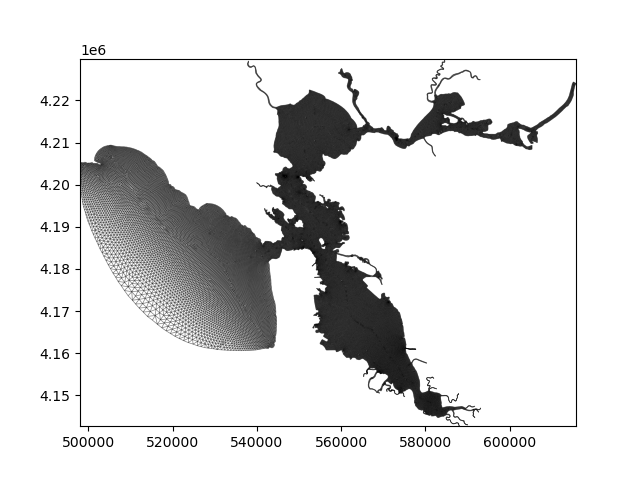

In [22]:
fig,ax=plt.subplots()
g.plot_edges(color='k',lw=0.5,alpha=0.5)

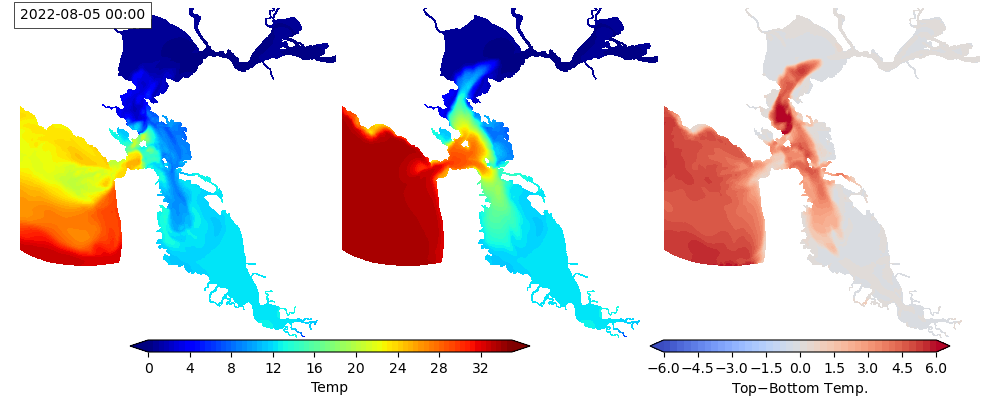

In [140]:
fig,axs = plt.subplots(1,3,figsize=(10,4))
zoom=(519562., 597707., 4137192., 4224297.)

fig.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.1,wspace=0.02)

topIdx=0
tidx=0
fld='salinity'
N=np.linspace(0,35,71)
coll0=g.contourf_node_values(ds[fld].isel(time=tidx,siglay_dim=topIdx),
                             #ds[fld].isel(time=tidx).mean(dim='siglay_dim'),
                             N,cmap='jet',extend='both',
                            ax=axs[0])
collN=g.contourf_node_values(ds[fld].isel(time=tidx,siglay_dim=-1),N,cmap='jet',extend='both',
                            ax=axs[1])
delta = ds.temp.isel(time=tidx,siglay_dim=topIdx) - ds.temp.isel(time=tidx,siglay_dim=-1)
collDelta=g.contourf_node_values(delta,np.linspace(-6,6,41),cmap='coolwarm',extend='both',
                            ax=axs[2])

y=0.12
xc=0.33
w=0.4
caxT  =fig.add_axes([xc-w/2,y,w,0.03])
xc=0.8
w=0.3
caxDT =fig.add_axes([xc-w/2,y,w,0.03])

plt.colorbar(coll0,cax=caxT,label='Temp',orientation='horizontal')
plt.colorbar(collDelta,cax=caxDT,label='Top$-$Bottom Temp.',orientation='horizontal')

axs[0].text(0.0,1., utils.strftime( ds.time.isel(time=tidx).values, "%Y-%m-%d %H:%M"),
            transform=axs[0].transAxes,va='top',bbox=dict(fc='w',lw=0.5))
for ax in axs:
    ax.axis('off')
    ax.axis('equal')
    ax.axis(zoom)

13932


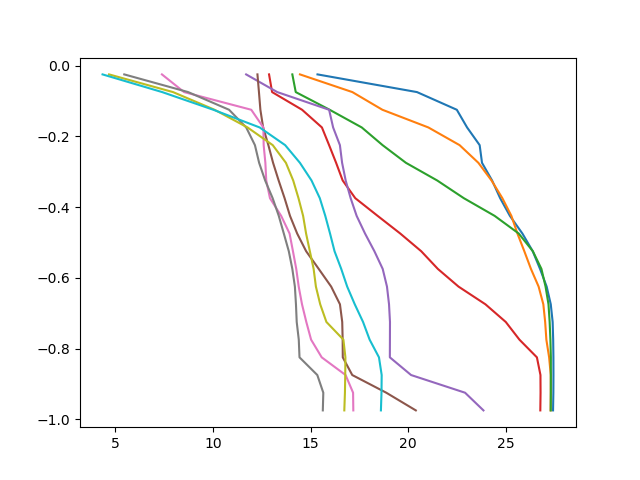

In [135]:
#pnt=np.array([557400,4.18090e6])
pnt=np.array([552330,4.18851e6])
#cell=g.select_cells_nearest(pnt)
node=g.select_nodes_nearest(pnt)
print(node)
plt.figure()
sig = ds.siglay.isel(node=node)
for tidx in range(10):
    #prof=ds.temp.isel(time=tidx,node=node)
    prof=ds.salinity.isel(time=tidx,node=node)
    plt.plot(prof,sig)

In [134]:
ds

<xarray.Dataset>
Dimensions:          (nply: 4, two: 2, node: 54120, nele: 102264, three: 3,
                      time: 145, siglay_dim: 20, siglev_dim: 21)
Coordinates:
    lon              (node) float32 237.0 237.0 237.0 ... 238.3 238.3 238.3
    lat              (node) float32 38.0 37.99 37.99 37.99 ... 38.16 38.16 38.16
    lonc             (nele) float32 ...
    latc             (nele) float32 ...
  * node             (node) int32 1 2 3 4 5 6 ... 54116 54117 54118 54119 54120
  * time             (time) datetime64[ns] 2022-08-05 ... 2022-08-11
    siglay           (siglay_dim, node) float32 -0.025 -0.025 ... -0.975 -0.975
    siglev           (siglev_dim, node) float32 -0.0 -0.0 -0.0 ... -1.0 -1.0
Dimensions without coordinates: nply, two, nele, three, siglay_dim, siglev_dim
Data variables: (12/18)
    x                (nply) float32 ...
    y                (nply) float32 ...
    requested_times  (two) |S26 ...
    cell             (nele) int32 ...
    h                (node) float32 ...
    nv               (three, nele) int32 93 93 3 94 ... 54118 54114 54114 54120
    ...               ...
    u                (time, siglay_dim, nele) float32 ...
    v                (time, siglay_dim, nele) float32 ...
    uwind_speed      (time, nele) float32 ...
    vwind_speed      (time, nele) float32 ...
    wet_nodes        (time, node) int32 ...
    wet_cells        (time, nele) int32 ...
Attributes: (12/17)
    note:                        Output from CO-OPS subsetting/Aggregation tool
    user_email:                  rustychris@gmail.com
    format:                      netCDF-4/HDF5 file
    title:                       SFBOFS
    institution:                 School for Marine Science and Technology
    source:                      FVCOM_4.3
    ...                          ...
    Tidal_Forcing:               Tidal Forcing Time Series Title: sfbofs late...
    River_Forcing:               THERE ARE 9 RIVERS IN THIS MODEL.\nRIVER INF...
    GroundWater_Forcing:         GROUND WATER FORCING IS OFF!
    Surface_Heat_Forcing:        FVCOM variable surface heat forcing file:\nF...
    Surface_Wind_Forcing:        FVCOM variable surface Wind forcing:\nFILE N...
    Surface_PrecipEvap_Forcing:  SURFACE PRECIPITATION FORCING IS OFF

In [129]:
np.diff(ds.siglay.isel(node=node).values)

array([-0.05      , -0.05      , -0.05000001, -0.04999998, -0.05000001,
       -0.04999998, -0.05000001, -0.05000001, -0.04999998, -0.04999998,
       -0.05000007, -0.04999995, -0.04999995, -0.05000007, -0.04999995,
       -0.05000007, -0.04999995, -0.04999995, -0.05000007], dtype=float32)

(array([1.7000e+01, 2.9754e+04, 2.4760e+03, 2.1380e+03, 3.0480e+03,
        3.4970e+03, 5.5220e+03, 6.3710e+03, 9.4900e+02, 3.4800e+02]),
 array([-1.31007385, -0.45687327,  0.39632732,  1.24952793,  2.10272837,
         2.95592904,  3.80912971,  4.66233015,  5.51553059,  6.3687315 ,
         7.22193193]),
 <BarContainer object of 10 artists>)

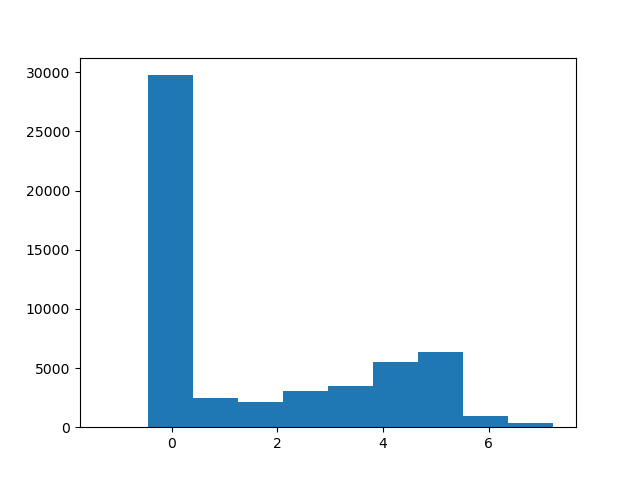

In [89]:
plt.figure()
plt.hist(delta)